In [3]:
import numpy as np
import h5py
from scipy.io import loadmat
import re
import matplotlib.pyplot as plt
from types import SimpleNamespace
import scipy
import warnings
from scipy.ndimage import median_filter, gaussian_filter

In [4]:
# import Python functions 
import sys
sys.path.append('./Python_Functions')

from Python_Functions.functions import cropProfmonImg, matstruct_to_dict, extractDAQBSAScalars, segment_centroids_and_com, plot2DbunchseparationVsCollimatorAndBLEN

In [5]:
# Sets data location
experiment = 'E338'
runname = '12710'

In [7]:
# Define XTCAV calibration
krf = 239.26
cal = 1167 # um/deg  http://physics-elog.slac.stanford.edu/facetelog/show.jsp?dir=/2025/11/13.03&pos=2025-$
streakFromGUI = cal*krf*180/np.pi*1e-6#um/um

In [8]:
# Sets the main beam energy
mainbeamE_eV = 10e9
# Sets the dnom value for CHER
dnom = 59.8e-3

# Sets the calibration value for SYAG in eV/m
SYAG_cal = 64.4e9


### Load dataset

In [9]:
# Loads dataset
dataloc = 'data/' + experiment + '/' + experiment + '_' + runname + '/' + experiment + '_'  +runname + '.mat'
mat = loadmat(dataloc,struct_as_record=False, squeeze_me=True)
data_struct = mat['data_struct']

In [10]:
# Extracts number of steps
stepsAll = data_struct.params.stepsAll
if stepsAll is None or len(np.atleast_1d(stepsAll)) == 0:
    stepsAll = 1

# calculate xt calibration factor
xtcalibrationfactor = data_struct.metadata.DTOTR2.RESOLUTION*1e-6/streakFromGUI/3e8

### Grab XTCAV images on DTOTR2

In [11]:
xrange = 100 
yrange = xrange
sigma = 5

In [22]:
xtcavImages_list = []
horz_proj_list = []

for a in range(len(stepsAll)):
    raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = 'data/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        Nrows = np.array(image_cropped).shape[0]
        img = median_filter(image_cropped, size=3)
        processed_image = gaussian_filter(img, sigma=sigma)
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_shifted, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)

In [23]:
# Keeps only the data with a common index
DTOTR2commonind = data_struct.images.DTOTR2.common_index -1 
horz_proj = horz_proj[:,DTOTR2commonind]
xtcavImages = xtcavImages[:,:,DTOTR2commonind]

In [24]:
Horz_proj = horz_proj

### Get the XTCAV phase on each shot (important if toggler is on)

In [14]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

ampl_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_A' in var)
xtcavAmpl = bsaScalarData[ampl_idx, :]

phase_idx = next(i for i, var in enumerate(bsaVars) if 'TCAV_LI20_2400_P' in var)
xtcavPhase = bsaScalarData[phase_idx, :]

xtcavOffShots = xtcavAmpl<0.1
xtcavPhase[xtcavOffShots] = 0 #Set this for ease of plotting

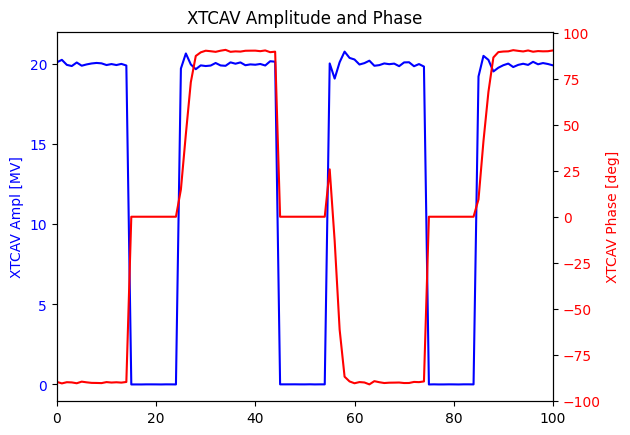

In [270]:
fig, ax1 = plt.subplots()
ax1.plot(xtcavAmpl, label='Amplitude', color='b')
ax1.set_ylabel('XTCAV Ampl [MV]', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(xtcavPhase, label='Phase', color='r')
ax2.set_ylabel('XTCAV Phase [deg]', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.xlim((0,100))

plt.title('XTCAV Amplitude and Phase')
plt.show()

### Plot sample images of the beam with tcav at +90 deg, 0 and -90 deg

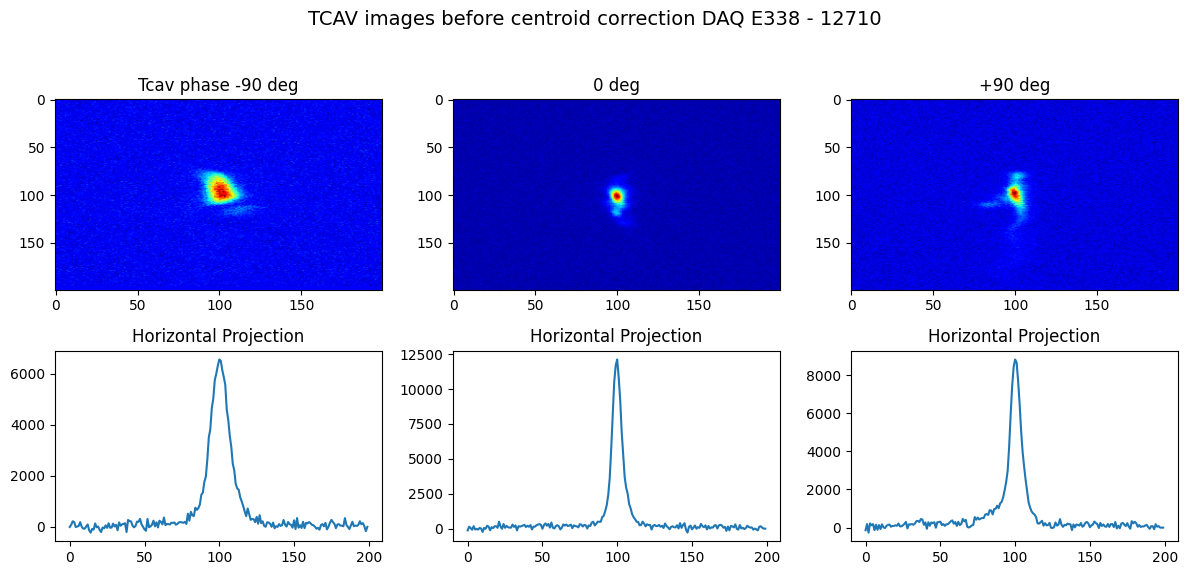

In [19]:
# Find the first shot where tcav is at -90, 0 and +90 deg
near_minus_90_idx = np.where((xtcavPhase >= -91) & (xtcavPhase <= -89))[0][1]
near_plus_90_idx = np.where((xtcavPhase >= 89) & (xtcavPhase <= 91))[0][1]
zero_idx = np.where(xtcavPhase == 0)[0][1]

sample_image_indices = [near_minus_90_idx, zero_idx, near_plus_90_idx]
plot_titles = ['Tcav phase -90 deg', '0 deg', '+90 deg']


# Define the x and yrange for cropping the image; Need to automate this
# figure;imagesc(sampleImage)

xrange = 100
yrange = xrange

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images before centroid correction DAQ {experiment} - {runname}', fontsize=14)

for i, idx in enumerate(sample_image_indices):
    if idx is None:
        continue

    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)
    horz_proj = np.sum(sample_image_cropped, axis=0)

    axs[0, i].imshow(sample_image_cropped, cmap='jet', aspect='auto')
    axs[0, i].set_title(plot_titles[i])

    axs[1, i].plot(horz_proj)
    axs[1, i].set_title("Horizontal Projection")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate centroid correction

In [15]:
from scipy.ndimage import median_filter, gaussian_filter

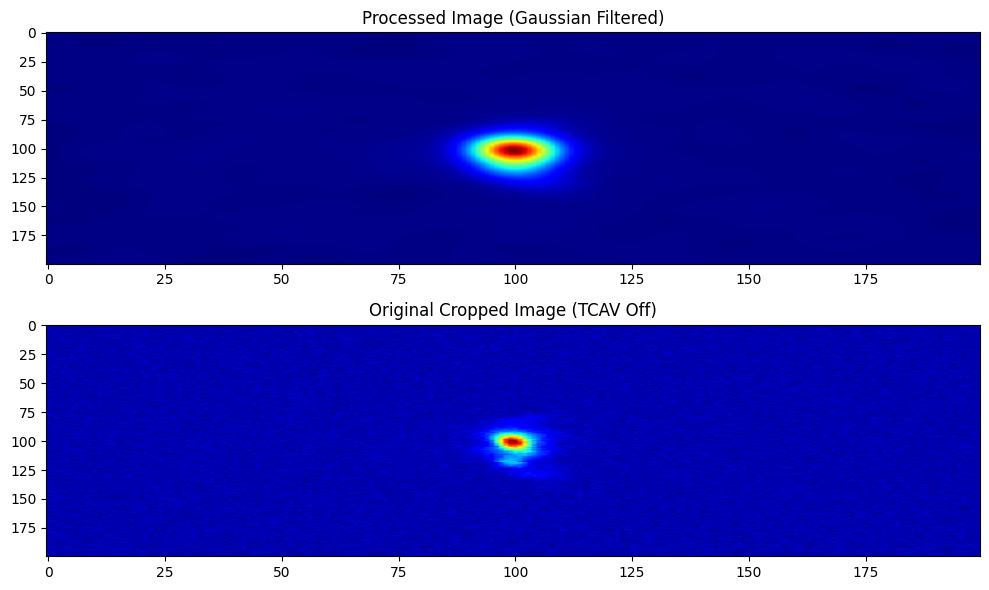

In [16]:
sample_image_tcav_off = xtcavImages[:, :, sample_image_indices[1]]
sample_image_tcav_off, _ = cropProfmonImg(sample_image_tcav_off, xrange, yrange, plot_flag=False)

img = median_filter(sample_image_tcav_off, size=3)
sigma = 5
processed_image = gaussian_filter(img, sigma=sigma)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.imshow(processed_image, cmap='jet', aspect='auto')
plt.title("Processed Image (Gaussian Filtered)")

plt.subplot(2, 1, 2)
plt.imshow(sample_image_tcav_off, cmap='jet', aspect='auto')
plt.title("Original Cropped Image (TCAV Off)")

plt.tight_layout()
plt.show()


### Apply centroid correction to images and replot

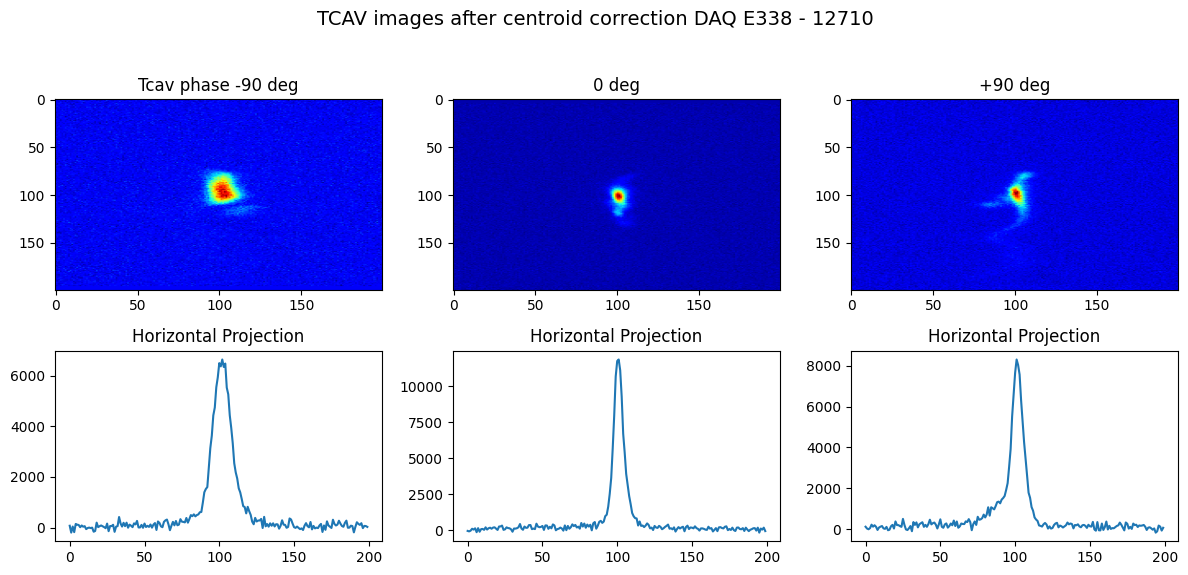

In [17]:
Nrows = np.array(sample_image_tcav_off).shape[0]
[centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images after centroid correction DAQ {experiment} - {runname}', fontsize=14)

for i, idx in enumerate(sample_image_indices):
    if idx is None:
        continue

    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)


    centroid_corrections = np.round((centers_of_mass/np.abs(centers_of_mass))*np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    horz_proj = np.sum(sample_image_shifted, axis=0)

    axs[0, i].imshow(sample_image_shifted, cmap='jet', aspect='auto')
    axs[0, i].set_title(plot_titles[i])

    axs[1, i].plot(horz_proj)
    axs[1, i].set_title("Horizontal Projection")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate the current profile normalizing the integral to the charge

NameError: name 'sample_image_indices' is not defined

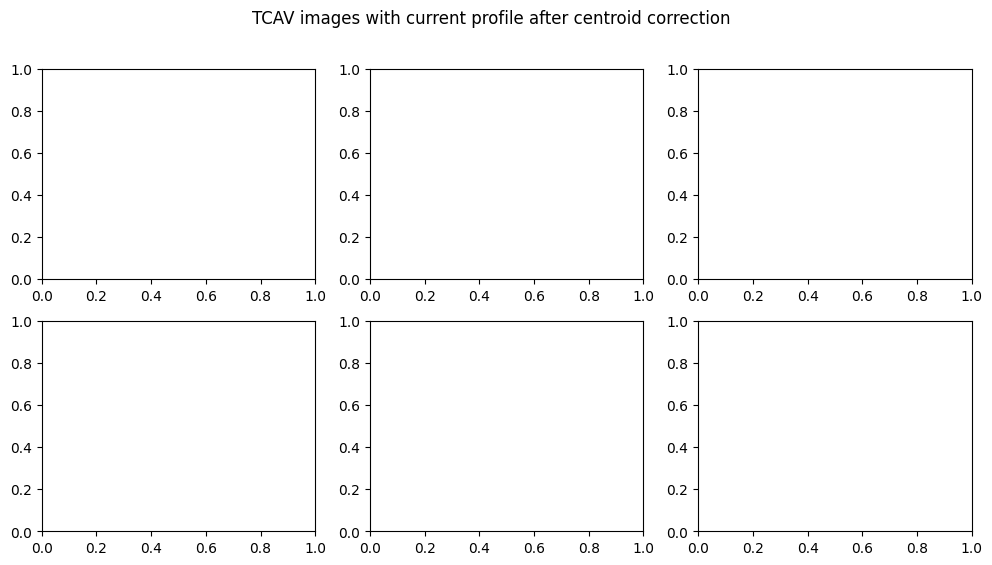

In [16]:
isChargePV = [bool(re.search(r'TORO_LI20_2452_TMIT', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(isChargePV) if val]
charge = bsaScalarData[pvidx, :] * 1.6e-19  # in C 

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle(f'TCAV images with current profile after centroid correction')

for i, (ij, idx) in enumerate([(i, idx) for i, idx in enumerate(sample_image_indices) if i != 1]):
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    # Centroid correction
    centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    sample_image_shifted = np.empty_like(sample_image_cropped)
    for row in range(sample_image_cropped.shape[0]):
        shift = -int(centroid_corrections[row])
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Current profile
    streakedProfile = np.sum(sample_image_shifted, axis=0)
    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar -= np.median(tvar)
    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
    currentProfile = streakedProfile * prefactor

    # Plot image
    axs[0, i].imshow(sample_image_shifted, cmap='jet', aspect='auto',
                     extent=[tvar[0]*1e15, tvar[-1]*1e15, 1, sample_image_shifted.shape[0]])
    axs[0, i].set_ylabel('y [pix]')
    axs[0, i].set_title(plot_titles[ij])

    # Plot projection
    axs[1, i].plot(tvar * 1e15, currentProfile * 1e-3)
    axs[1, i].set_xlabel('Time [fs]')
    axs[1, i].set_ylabel('Current [kA]')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Loop thru all +90 and -90 deg shots and calculate the current profile

In [273]:
horz_proj.shape

(200,)

In [284]:
Horz_proj[:,2]

array([ 6.200e+01,  5.700e+01,  1.810e+02,  1.090e+02,  1.200e+01,
        1.010e+02,  9.800e+01,  1.520e+02,  1.440e+02, -1.400e+01,
        4.700e+01,  4.900e+01, -5.400e+01, -2.200e+01,  2.400e+01,
        1.000e+00,  2.400e+01, -5.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  1.050e+02,  4.180e+02,
        1.066e+03,  1.679e+03,  1.792e+03,  1.954e+03,  2.410e+03,
        2.429e+03,  2.568e+03,  2.402e+03,  2.615e+03,  2.592e

In [285]:
np.sum(sample_image_cropped, axis=0)

array([ 0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00, -3.700e+01,  1.280e+02,  3.050e+02,  7.900e+01,
        1.940e+02,  1.170e+02, -1.000e+01,  8.000e+01,  3.900e+01,
       -9.400e+01, -1.200e+01, -1.200e+01, -8.900e+01,  6.200e+01,
        2.800e+01,  8.000e+00, -1.500e+01,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_79921/1587424537.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)
/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_79921/1587424537.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)


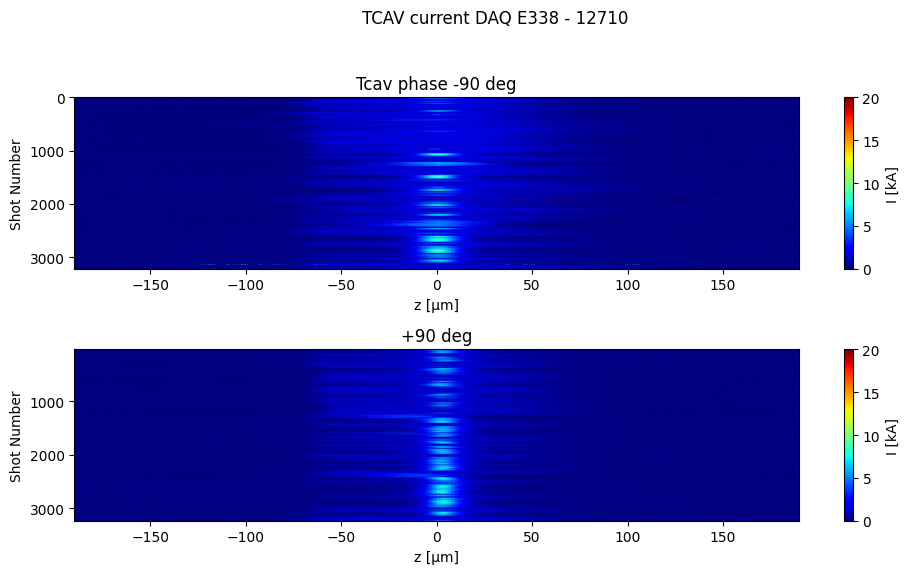

In [25]:
# Note here i'm assuming the centroid correction can be taken from a single 
#    tcav off image. A better treatment would find the nearest tcav off image
#   in the dataset and use that to apply the centroid correction on each shot

minus_90_idx = np.where((xtcavPhase >= -90.5) & (xtcavPhase <= -89.5))[0]
plus_90_idx = np.where((xtcavPhase >= 89.5) & (xtcavPhase <= 90.5))[0]

currentProfile_minus_90 = []
currentProfile_plus_90 = []

# Process -90 degree shots
for ij in range(len(minus_90_idx)):
    idx = minus_90_idx[ij]
    sample_image = xtcavImages[:, :, idx]
    sample_image_cropped, _ = cropProfmonImg(sample_image, xrange, yrange, plot_flag=False)

    centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
    centroid_corrections[np.isnan(centroid_corrections)] = 0

    # Apply row-wise shift based on centroid correction
    sample_image_shifted = np.empty_like(sample_image_cropped)
    
    for row in range(sample_image_cropped.shape[0]):
        shift = -centroid_corrections[row]
        sample_image_shifted[row] = np.roll(sample_image_cropped[row], shift)

    # Calculate the current profile from the streaked projection
    streakedProfile = np.sum(sample_image_cropped, axis=0)

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_minus_90.append(currentProfile)

# Process +90 degree shots
for ij in plus_90_idx:
    streakedProfile = horz_proj[:,ij]

    tvar = np.arange(1, len(streakedProfile) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero

    prefactor = charge[0, idx] / np.trapz(streakedProfile, tvar)

    currentProfile = 1e-3 * streakedProfile * prefactor  # Convert to kA
    currentProfile_plus_90.append(currentProfile)

# Convert lists to arrays for plotting
currentProfile_minus_90 = np.array(currentProfile_minus_90)
currentProfile_plus_90 = np.array(currentProfile_plus_90)

# Plot
plt.figure(figsize=(10, 6))

# Subplot for -90°
plt.subplot(2, 1, 1)
extent_x = tvar * 3e8 * 1e6  # Convert to microns
plt.imshow(currentProfile_minus_90, aspect='auto', cmap='jet', vmin=0, vmax=20, extent=[extent_x[0], extent_x[-1], minus_90_idx[-1], minus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[0])
plt.colorbar(label='I [kA]')

# Subplot for +90°
plt.subplot(2, 1, 2)
plt.imshow(currentProfile_plus_90, aspect='auto', cmap='jet', vmin=0, vmax=20,extent=[extent_x[0], extent_x[-1], plus_90_idx[-1], plus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[2])
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Calculate the drive-witness separation and compare with BLEN

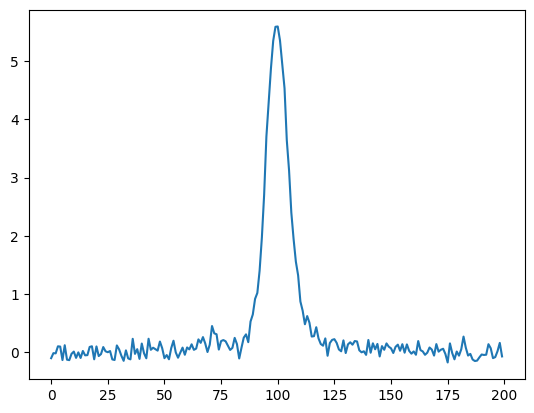

In [213]:
plt.plot(currentProfile_plus_90[-1,:])
plt.show()

In [214]:
from scipy.signal import find_peaks, peak_prominences

all_idx = np.concatenate((minus_90_idx, plus_90_idx), axis = 0)

for ij in range(len(plus_90_idx)):
    profile = currentProfile_plus_90[ij, :] 
    peaks, _ = find_peaks(profile)
    prominences = peak_prominences(profile, peaks)[0]
    if len(prominences) < 2:
        bunchSeparation_plus_90[ij] = 0
        continue
    
    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_plus_90[ij] = peak_separation * xtcalibrationfactor
    currentRatio_plus_90[ij] = profile[pos[0]] / profile[pos[1]]

bunch_sep_plus_90_um = bunchSeparation_plus_90 * 3e8 * 1e6


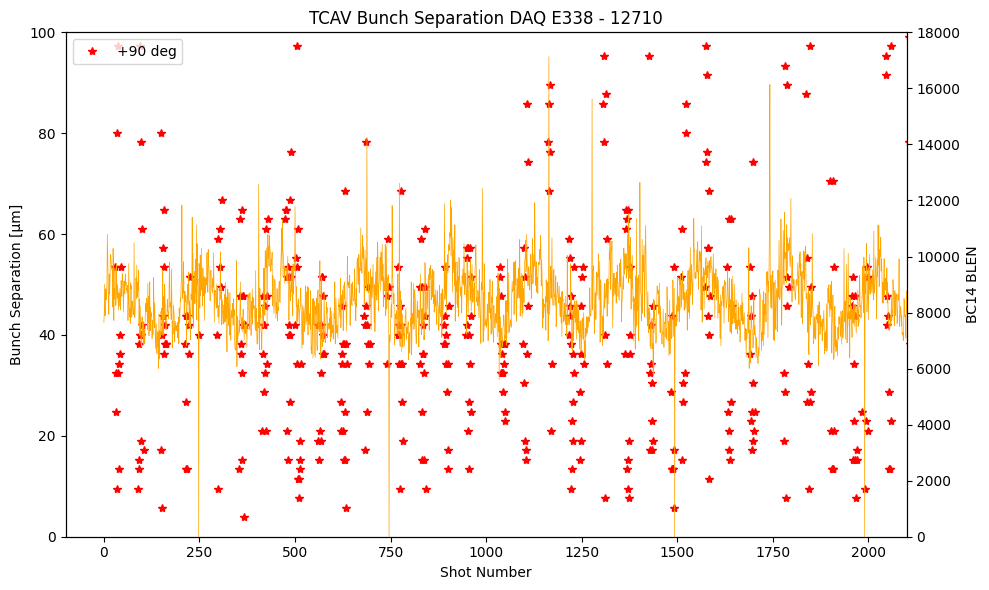

In [ ]:
# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bunch separations
# ln1 = ax1.plot(minus_90_idx, bunch_sep_minus_90_um, '*b', label='-90 deg')
ln2 = ax1.plot(plus_90_idx[goodShots], bunch_sep_plus_90_um[goodShots], '*r', label='+90 deg')

ax1.set_xlabel('Shot Number')
ax1.set_ylabel('Bunch Separation [μm]', color='black')
ax1.set_ylim(0, 100)  

# Create secondary y-axis for BC14 BLEN
ax2 = ax1.twinx()
shot_numbers = np.arange(bc14BLEN.shape[1])
ln3 = ax2.plot(shot_numbers,bc14BLEN[0], color = 'orange', linewidth=0.5)
ax2.set_ylabel('BC14 BLEN', color='black')
ax2.set_ylim(0, 18000)

# Combine legends
lines = ln2 
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Title and appearance
plt.title(f'TCAV Bunch Separation DAQ {experiment} - {runname}')
plt.xlim((-100,2100))
fig.tight_layout()
fig.patch.set_facecolor('white')

plt.show()

In [220]:
np.array([bool(re.search(r'BLEN', pv)) for pv in bsaVars])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [302]:
bc14BLEN[0]

array([7648.046875 , 7999.796875 , 9014.8515625, ..., 7406.8515625,
       7383.40625  , 7470.5      ], shape=(3233,))

In [186]:
prominences[29] - prominences[30]

np.float64(4.969973215976704)

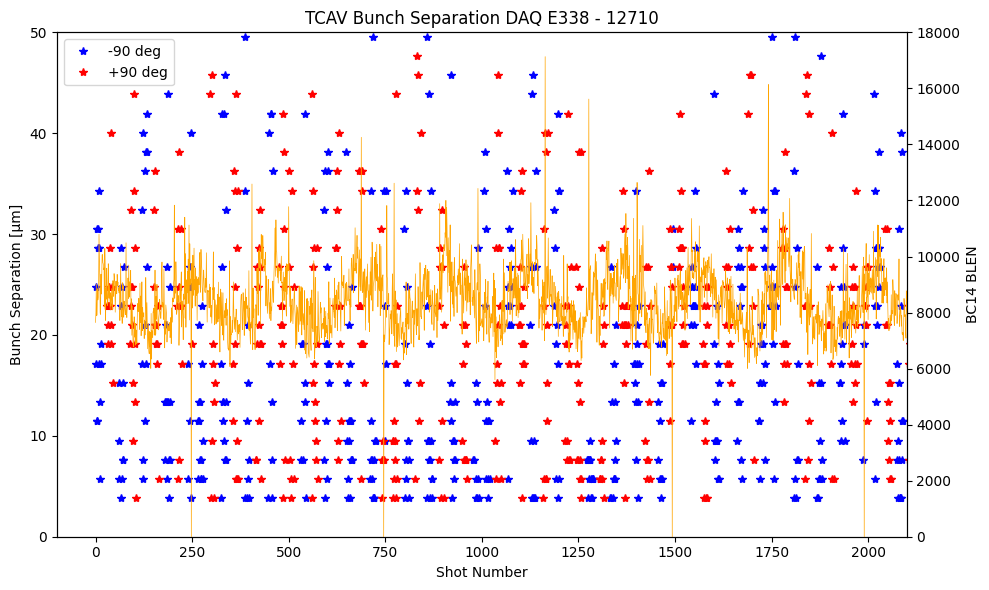

In [182]:
ispv = [bool(re.search(r'BLEN_LI14_888_BRAW', pv)) for pv in bsaVars]
pvidx = [i for i, val in enumerate(ispv) if val]
bc14BLEN = bsaScalarData[pvidx,:]
separationCutoff = 0.05 # fraction of the drive/witness peak current for filtering

sorted_bc14BLEN = np.sort(bc14BLEN)
sort_BC14BLEN_indices = np.argsort(bc14BLEN)

from scipy.signal import find_peaks

bunchSeparation_minus_90 = np.zeros(len(minus_90_idx))
currentRatio_minus_90 = np.zeros(len(minus_90_idx))

for ij in range(len(minus_90_idx)):
    profile = currentProfile_minus_90[ij, :]
    peaks, properties = find_peaks(profile)
    prominences = properties.get("prominences", profile[peaks])  # fallback to height if no prominences

    if len(prominences) < 2:
        bunchSeparation_minus_90[ij] = 0
        continue

    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_minus_90[ij] = peak_separation * xtcalibrationfactor
    currentRatio_minus_90[ij] = profile[pos[0]] / profile[pos[1]]

bunchSeparation_plus_90 = np.zeros(len(plus_90_idx))
currentRatio_plus_90 = np.zeros(len(plus_90_idx))

for ij in range(len(plus_90_idx)):
    profile = currentProfile_plus_90[ij, :]
    peaks, properties = find_peaks(profile)
    prominences = properties.get("prominences", profile[peaks])

    if len(prominences) < 2:
        bunchSeparation_plus_90[ij] = 0
        continue

    top2_indices = np.argsort(prominences)[-2:]
    pos = peaks[top2_indices]

    peak_separation = abs(pos[0] - pos[1])

    if abs(prominences[top2_indices[0]]) * separationCutoff > abs(prominences[top2_indices[1]]):
        peak_separation = 0

    bunchSeparation_plus_90[ij] = peak_separation * xtcalibrationfactor
    currentRatio_plus_90[ij] = profile[pos[0]] / profile[pos[1]]

# Convert to microns
bunch_sep_minus_90_um = bunchSeparation_minus_90 * 3e8 * 1e6
bunch_sep_plus_90_um = bunchSeparation_plus_90 * 3e8 * 1e6

# Create figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bunch separations
ln1 = ax1.plot(minus_90_idx, bunch_sep_minus_90_um, '*b', label='-90 deg')
ln2 = ax1.plot(plus_90_idx, bunch_sep_plus_90_um, '*r', label='+90 deg')

ax1.set_xlabel('Shot Number')
ax1.set_ylabel('Bunch Separation [μm]', color='black')
ax1.set_ylim(0, 50)  

# Create secondary y-axis for BC14 BLEN
ax2 = ax1.twinx()
shot_numbers = np.arange(bc14BLEN.shape[1])
ln3 = ax2.plot(shot_numbers,bc14BLEN[0], color = 'orange', linewidth=0.5)
ax2.set_ylabel('BC14 BLEN', color='black')
ax2.set_ylim(0, 18000)

# Combine legends
lines = ln1 + ln2 
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Title and appearance
plt.title(f'TCAV Bunch Separation DAQ {experiment} - {runname}')
plt.xlim((-100,2100))
fig.tight_layout()
fig.patch.set_facecolor('white')

plt.show()


### Calculate the charge in the drive and witness beams based on DTOTR projection

In [ ]:
steps = data_struct.scalars.steps[DTOTR2commonind]
energyProjection = np.sum(xtcavImages, axis=1)

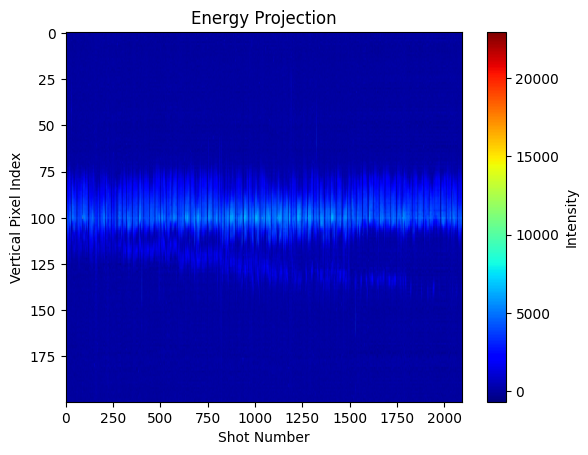

In [ ]:
plt.figure()
plt.imshow(energyProjection, aspect='auto', cmap='jet')
plt.title("Energy Projection")
plt.xlabel("Shot Number")
plt.ylabel("Vertical Pixel Index")
plt.colorbar(label='Intensity')
plt.show()

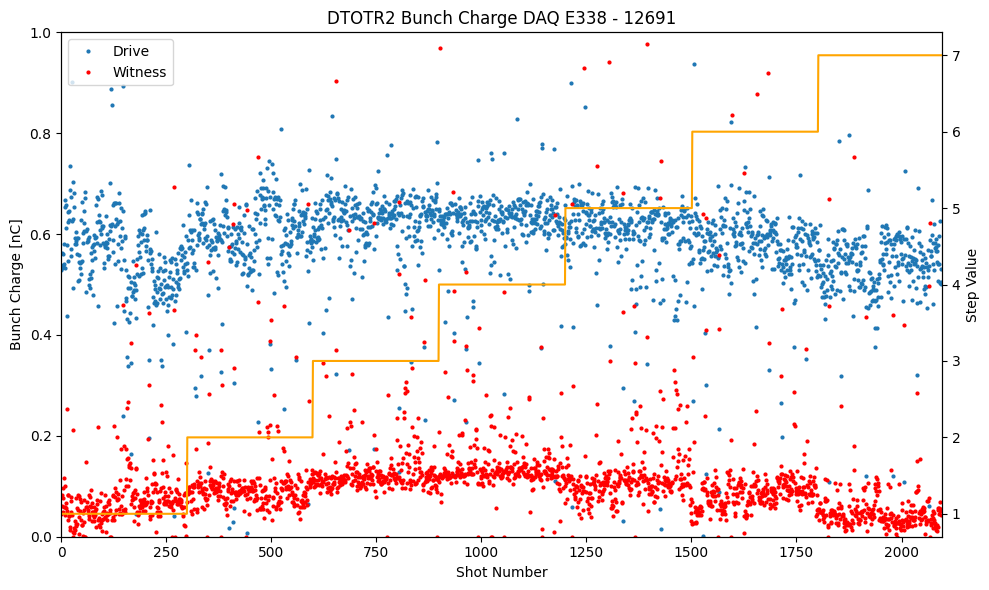

In [ ]:
idxDrive = 115 # index in the energy projection that separates Drive-witness - determine it by looking at the above waterfall plot

driveBeamEnergyProj = energyProjection[:idxDrive, :] 
witnessBeamEnergyProj = energyProjection[idxDrive:, :] 

chargeInDrive = charge * np.sum(driveBeamEnergyProj, axis=0) / np.sum(energyProjection, axis=0)
chargeInWitness = charge * np.sum(witnessBeamEnergyProj, axis=0) / np.sum(energyProjection, axis=0)

plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Left y-axis
ax1.set_ylabel('Bunch Charge [nC]')
ax1.set_ylim(0, 1)
ln1 = ax1.plot(chargeInDrive[0] * 1e9, '.', label='Drive', ms = 4)
ln2 = ax1.plot(chargeInWitness[0] * 1e9, '.r', label='Witness', ms = 4)

# Right y-axis (step values)
ax2 = ax1.twinx()
ln3 = ax2.plot(steps, '-', color='orange', label='Step Value')
ax2.set_ylabel('Step Value')

# X-axis
ax1.set_xlabel('Shot Number')
ax1.set_xlim([0, len(steps)])

# Combine legend from both axes
lines = ln1 + ln2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title(f'DTOTR2 Bunch Charge DAQ {experiment} - {runname}')
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

### Calculate the charge in the drive and witness beams based on SYAG projection

In [ ]:
xtcavImages_list = []
horz_proj_list = []

for a in range(len(stepsAll)):
    raw_path = data_struct.images.DTOTR2.loc[a]
    match = re.search(rf'({experiment}_\d+/images/DTOTR2/DTOTR2_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    DTOTR2datalocation = 'data/'+ experiment + '/' + match.group(0)

    with h5py.File(DTOTR2datalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    DTOTR2data_step = np.transpose(data_raw, (2, 1, 0))
    xtcavImages_step = DTOTR2data_step - data_struct.backgrounds.DTOTR2[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(DTOTR2data_step.shape[2]):
        if idx is None:
            continue
        image = xtcavImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        Nrows = np.array(image_cropped).shape[0]
        img = median_filter(image_cropped, size=3)
        processed_image = gaussian_filter(img, sigma=sigma)
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        horz_proj_idx = np.sum(image_shifted, axis=0)
        horz_proj_idx = horz_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        
        # combine current profiles into one array 
        horz_proj_list.append(horz_proj_idx)

        # combine images into one array 
        xtcavImages_list.append(image_shifted)

xtcavImages = np.concatenate(xtcavImages_list, axis=2)
horz_proj = np.concatenate(horz_proj_list, axis=1)

In [ ]:
SYAG_images_list = []
SYAG_proj_list = []

for a in range(len(stepsAll)):
    raw_path = data_struct.images.SYAG.loc[a]
    match = re.search(rf'({experiment}_\d+/images/SYAG/SYAG_data_step\d+\.h5)', raw_path)
    if not match:
        raise ValueError(f"Path format invalid or not matched: {raw_path}")

    SYAGdatalocation = 'data/'+ experiment + '/' + match.group(0)

    with h5py.File(SYAGdatalocation, 'r') as f:
        data_raw = f['entry']['data']['data'][:].astype(np.float64)  # shape: (N, H, W)
    
    # Transpose to shape: (H, W, N)
    SYAGdata_step = np.transpose(data_raw, (2, 1, 0))
    SYAGImages_step = SYAGdata_step - data_struct.backgrounds.SYAG[:,:,np.newaxis].astype(np.float64)
    
    for idx in range(SYAGdata_step.shape[2]):
        if idx is None:
            continue
        image = SYAGImages_step[:,:,idx]
        
        # crop images 
        image_cropped, _ = cropProfmonImg(image, xrange, yrange, plot_flag=False)
        Nrows = np.array(image_cropped).shape[0]
        img = median_filter(image_cropped, size=3)
        processed_image = gaussian_filter(img, sigma=sigma)
        [centroidIndices, centers_of_mass] = segment_centroids_and_com(processed_image, Nrows,1)

        # centroid correcion
        centroid_corrections = np.round((centers_of_mass / np.abs(centers_of_mass)) * np.abs(centers_of_mass) - centers_of_mass.shape[0] / 2)
        centroid_corrections[np.isnan(centroid_corrections)] = 0

        # shift images
        image_shifted = np.empty_like(image_cropped)
        for row in range(image_cropped.shape[0]):
            shift = int(-centroid_corrections[row])
            image_shifted[row] = np.roll(image_cropped[row], shift)
        # calcualte current profiles 
        SYAG_proj_idx = np.sum(image_shifted, axis=0)
        SYAG_proj_idx = SYAG_proj_idx[:,np.newaxis]
        image_shifted = image_shifted[:, :, np.newaxis]
        
        # combine current profiles into one array 
        SYAG_proj_list.append(SYAG_proj_idx)

        # combine images into one array 
        SYAG_images_list.append(image_shifted)

syagImages = np.concatenate(SYAG_images_list, axis=2)
syagProjection = np.concatenate(SYAG_proj_list, axis=1)

In [ ]:
# Keeps only the data with a common index
SYAGcommonind = data_struct.images.SYAG.common_index -1 
syagProjection = syagProjection[:,SYAGcommonind]
syagImages = syagImages[:,:,SYAGcommonind]

In [211]:
idxDrive = 670 # index in the energy projection that separates Drive-witness - determine it by looking at the above waterfall plot

driveBeamsyagProj = syagProjection[:idxDrive, :] 
witnessBeamsyagProj = syagProjection[idxDrive:, :] 

chargeInDriveFromSyag = charge * np.sum(driveBeamsyagProj, axis=0) / np.sum(syagProjection, axis=0)
chargeInWitnessFromSyag = charge * np.sum(witnessBeamsyagProj, axis=0) / np.sum(syagProjection, axis=0)

plt.figure(figsize=(10, 6))
ax1 = plt.gca()

# Left y-axis
ax1.set_ylabel('Bunch Charge [nC]')
ax1.set_ylim(0, 1)
ln1 = ax1.plot(chargeInDriveFromSyag[0] * 1e9, '.', label='Drive', ms = 4)
ln2 = ax1.plot(chargeInWitnessFromSyag[0] * 1e9, '.r', label='Witness', ms = 4)

# Right y-axis (step values)
ax2 = ax1.twinx()
ln3 = ax2.plot(steps, '-', color='orange', label='Step Value')
ax2.set_ylabel('Step Value')

# X-axis
ax1.set_xlabel('Shot Number')
ax1.set_xlim([0, len(steps)])

# Combine legend from both axes
lines = ln1 + ln2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title(f'SYAG Bunch Charge DAQ {experiment} - {runname}')
plt.tight_layout()
plt.gcf().set_facecolor('white')
plt.show()

NameError: name 'syagProjection' is not defined

In [ ]:

# Process +90 deg shots 
currentProfile_plus_90_SYAG = []

for ij in range(len(plus_90_idx)): 
    idx = plus_90_idx[ij]
    tvar = np.arange(1, len(syagProjection) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero
    prefactor = charge[0, idx] / np.trapz(syagProjection[:,idx], tvar)
    currentProfile_SYAG = 1e-3 * syagProjection[:,idx] * prefactor  # Convert to kA
    currentProfile_plus_90_SYAG.append(currentProfile_SYAG)

driverPeak_SYAG = np.max(currentProfile_plus_90_SYAG, axis = 1)
# predictor = bsaScalarData[:,plus_90_idx]

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_2177/747637428.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(syagProjection[:,idx], tvar)


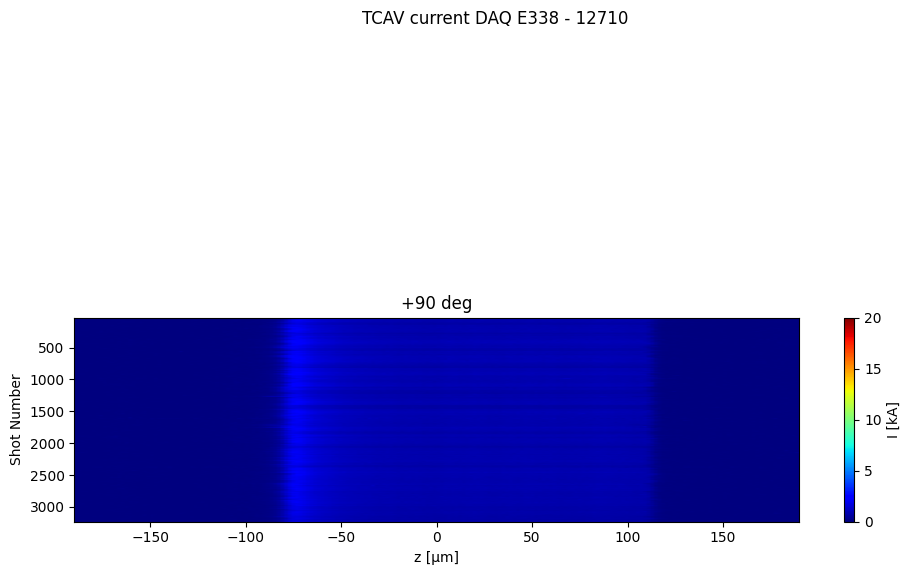

In [ ]:
# Plot
plt.figure(figsize=(10, 6))

# Subplot for +90°
plt.subplot(2, 1, 2)
plt.imshow(currentProfile_plus_90_SYAG, aspect='auto', cmap='jet', vmin=0, vmax=20,extent=[extent_x[0], extent_x[-1], plus_90_idx[-1], plus_90_idx[0]])
plt.xlabel('z [μm]')
plt.ylabel('Shot Number')
plt.title(plot_titles[2])
plt.colorbar(label='I [kA]')

plt.suptitle(f"TCAV current DAQ {experiment} - {runname}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2d Heatmap

### Now fit a 2D function to the data an plot the surface

In [1]:
# Define the data
X = bc14BLEN[0][plus_90_idx]
Y = steps[plus_90_idx]
Z = bunch_sep_plus_90_um # in microns 

# Filter good shots
goodShots = np.where((Z < 250) & (Z > 0))
X = X[goodShots]
Y = Y[goodShots]
Z = Z[goodShots]

x_min = 6000
x_max = 12000

# Create a mask for the subset
subset_mask = (X >= x_min) & (X <= x_max)

# Apply mask to all arrays
X = X[subset_mask]
Y = Y[subset_mask]
Z = Z[subset_mask]

# Combine X and Y into a matrix with two columns
XY = np.column_stack((X, Y))


NameError: name 'bc14BLEN' is not defined

In [ ]:
# Fit a polynomial surface to the data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.interpolate import griddata
from sklearn.pipeline import make_pipeline

fit_deg = 2

model = make_pipeline(PolynomialFeatures(fit_deg), LinearRegression())
model.fit(XY, Z)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [195]:
# Create a grid for plotting
N = 200
x = np.linspace(np.min(X), np.max(X), N)
y = np.linspace(np.min(Y), np.max(Y), N)
Xi, Yi = np.meshgrid(x, y)

# Evaluate the model on a grid
grid_points = np.vstack((Xi.ravel(), Yi.ravel())).T
Zi_fit = model.predict(grid_points).reshape(Xi.shape)
# Interpolate original Z data onto the grid
Zi_data = griddata((X, Y), Z, (Xi, Yi), method='linear')

# Create figure
fig = plt.figure(figsize=(15, 5))

# Plot original data
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(Xi, Yi, Zi_data, cmap='jet', edgecolor='none')
ax1.set_title('Original Data (+90°)')
ax1.set_xlabel('BC14 BLEN')
ax1.set_ylabel('Step Number')
fig.colorbar(surf1, ax=ax1, label='Bunch Sep. [μm]')
ax1.set_zlim(0, 250)

# Plot fitted model
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
surf2 = ax2.plot_surface(Xi, Yi, Zi_fit, cmap='jet', edgecolor='none')
ax2.set_title('Fitted Model (+90°)')
ax2.set_xlabel('BC14 BLEN')
ax2.set_ylabel('Step Number')
fig.colorbar(surf1, ax=ax2, label='Bunch Sep. [μm]')
ax2.set_zlim(0, 250)

plt.suptitle(f'DTOTR2 Bunch Separation Fit vs Original (+90°) — {experiment} - {runname}', fontsize=14)
plt.tight_layout()
plt.show()

NameError: name 'model' is not defined

<Figure size 1500x500 with 0 Axes>

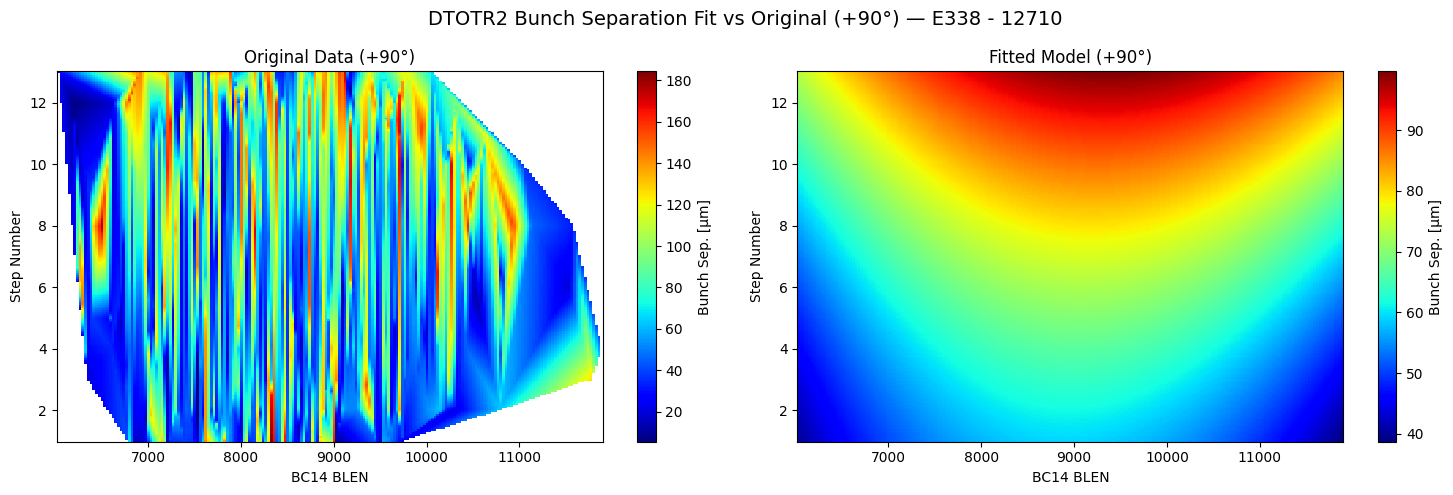

In [ ]:
# Create a grid for plotting

N = 200
x = np.linspace(np.min(X), np.max(X), N)
y = np.linspace(np.min(Y), np.max(Y), N)
Xi, Yi = np.meshgrid(x, y)

# Evaluate the model on a grid
grid_points = np.vstack((Xi.ravel(), Yi.ravel())).T
Zi_fit = model.predict(grid_points).reshape(Xi.shape)
# Interpolate original Z data onto the grid
Zi_data = griddata((X, Y), Z, (Xi, Yi), method='linear')

# Create figure
fig = plt.figure(figsize=(15, 5))

# Plot original data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
c1 = ax1.pcolormesh(Xi, Yi, Zi_data, cmap='jet', shading='auto')
ax1.set_title('Original Data (+90°)')
ax1.set_xlabel('BC14 BLEN')
ax1.set_ylabel('Step Number')
fig.colorbar(c1, ax=ax1, label='Bunch Sep. [μm]')

# Plot fitted model
c2 = ax2.pcolormesh(Xi, Yi, Zi_fit, cmap='jet', shading='auto')
ax2.set_title('Fitted Model (+90°)')
ax2.set_xlabel('BC14 BLEN')
ax2.set_ylabel('Step Number')
fig.colorbar(c2, ax=ax2, label='Bunch Sep. [μm]')

plt.suptitle(f'DTOTR2 Bunch Separation Fit vs Original (+90°) — {experiment} - {runname}', fontsize=14)
plt.tight_layout()
plt.show()

In [194]:
model.score(XY,Z)

NameError: name 'model' is not defined

### Calculate the bunch length in the drive and witness beams by fitting a biGaussian

In [ ]:
bc14BLEN[0][plus_90_idx].shape
steps[plus_90_idx].shape
bunch_sep_plus_90_um.shape


(842,)

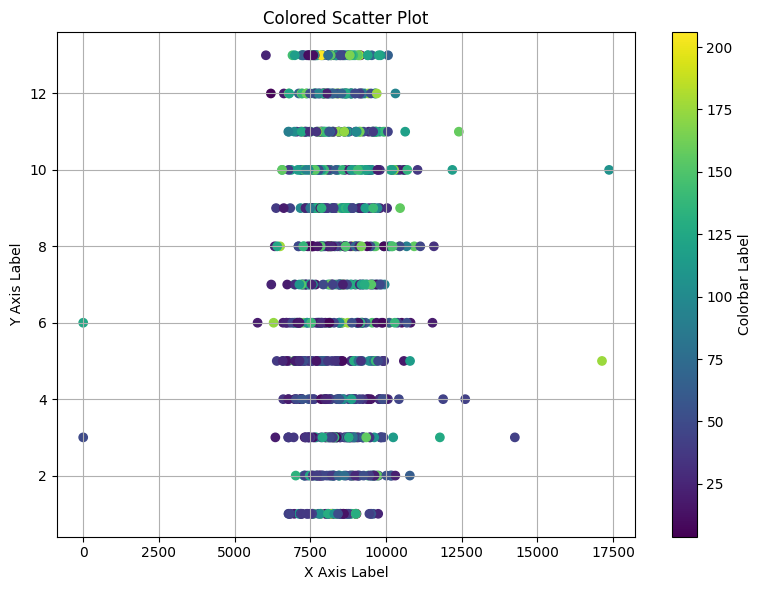

In [ ]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(bc14BLEN[0][plus_90_idx], steps[plus_90_idx], c=bunch_sep_plus_90_um, cmap='viridis')  # You can change 'viridis' to 'plasma', 'jet', etc.
cb = plt.colorbar(sc)
cb.set_label('Colorbar Label')  # Label for colorbar

plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.title('Colored Scatter Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
from scipy.optimize import curve_fit

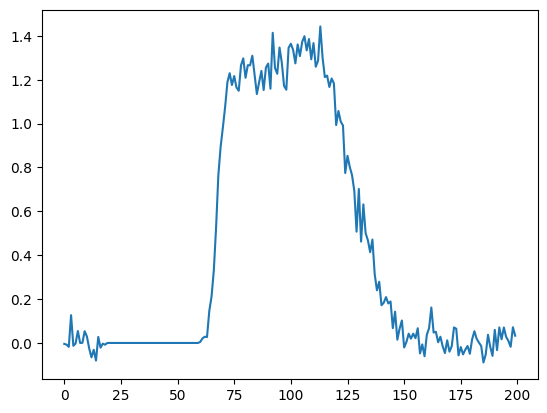

In [371]:
plt.plot(currentProfile_plus_90[400,:])
plt.show()

In [86]:
mean1.shape

(728,)

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_79921/2982088827.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


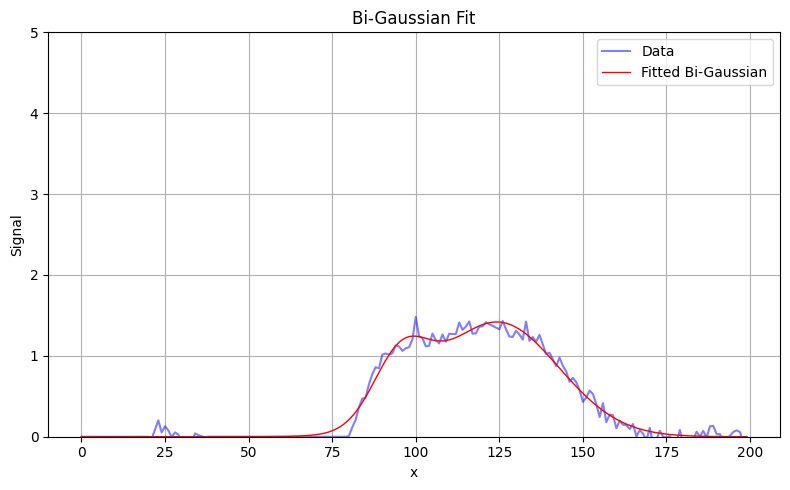

In [126]:
# fit bi-Gaussian to -90 deg 

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
amp2 = []
sigma1 = []
sigma2 = []
R_squared = []

for ij in range(len(minus_90_idx)):
    y = currentProfile_minus_90[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    initial_guess = [np.max(y), 100, 4, np.max(y)*0.2, 50 + ij * 0.05, 4]

    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    amp2.append(A2)
    mean2.append(mu2_val)
    sigma1.append(sig1)
    sigma2.append(sig2)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
amp2 = np.array(amp2)
mean2 = np.array(mean2)
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

# Plot the sigma of the drive and witness
# Plot the data and the fit
zvar = tvar * 3e8 * 1e6  # in microns
sigmadrive_minus90 = sigma1 * abs(zvar[1] - zvar[0])
sigmawit_minus90 = sigma2 * abs(zvar[1] - zvar[0])

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b-', label='Data', ms = 3, alpha = 0.5)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylim((0,5))
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [225]:
amp2[-1]

np.float64(0.27965728707337806)

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_79921/1112352346.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)


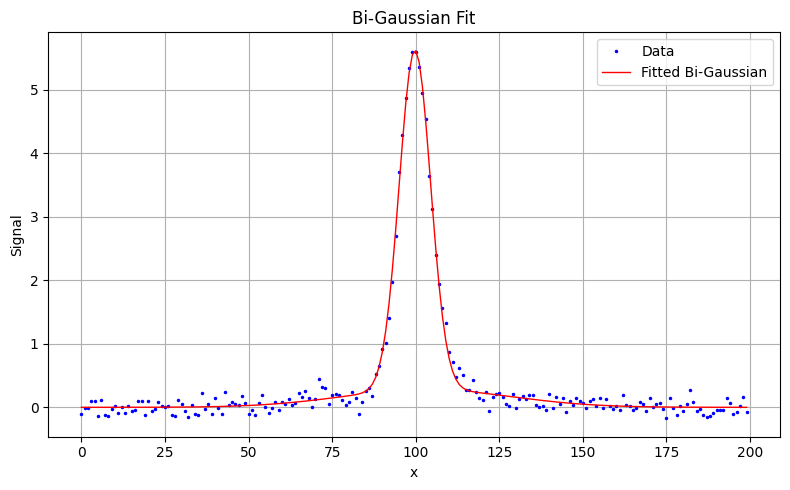

In [143]:
# fit bi-Gaussian to +90 deg 

# Define the bi-Gaussian function
def bi_gaussian(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return (A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) +
            A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2)))

mean1 = []
mean2 = []
amp2 = [] 
sigma1 = []
sigma2 = []
R_squared = []

for ij in range(len(plus_90_idx)):
    y = currentProfile_plus_90[ij, :]
    x = np.arange(len(y))

    # Initial guess: [A1, mu1, sigma1, A2, mu2, sigma2]
    initial_guess = [np.max(y), 100, 4, np.max(y)*0.1, 25 + ij * 0.05, 4]

    try:
        popt, pcov = curve_fit(bi_gaussian, x, y, p0=initial_guess, maxfev=5000)
    except RuntimeError:
        print(f"Fit failed at index {ij}")
        mean1.append(np.nan)
        mean2.append(np.nan)
        sigma1.append(np.nan)
        sigma2.append(np.nan)
        R_squared.append(np.nan)
        continue

    # Extract parameters
    A1, mu1_val, sig1, A2, mu2_val, sig2 = popt
    mean1.append(mu1_val)
    mean2.append(mu2_val)
    amp2.append(A2)
    sigma1.append(sig1)
    sigma2.append(sig2)

    # Evaluate fit
    y_fit = bi_gaussian(x, *popt)
    SST = np.sum((y - np.mean(y))**2)
    SSR = np.sum((y - y_fit)**2)
    R_squared.append(1 - SSR / SST)

# Convert results to arrays
mean1 = np.array(mean1)
mean2 = np.array(mean2)
amp2 = np.array(amp2 )
sigma1 = np.array(sigma1)
sigma2 = np.array(sigma2)
R_squared = np.array(R_squared)

# Plot the sigma of the drive and witness
# Plot the data and the fit
zvar = tvar * 3e8 * 1e6  # in microns
sigmadrive_minus90 = sigma1 * abs(zvar[1] - zvar[0])
sigmawit_minus90 = sigma2 * abs(zvar[1] - zvar[0])

# Plot a single fit (last one by default)
plt.figure(figsize=(8, 5))
plt.plot(x, y, 'b.', label='Data', ms = 3)
plt.plot(x, bi_gaussian(x, *popt), 'r-', label='Fitted Bi-Gaussian', linewidth = 1)
plt.xlabel('x')
plt.ylabel('Signal')
plt.title('Bi-Gaussian Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [324]:
np.max(mean2)

np.float64(528.8638856251623)

In [325]:
goodShots = np.array(np.where((amp2 > 0) & (amp2 < 2) & (mean2 < 150)))

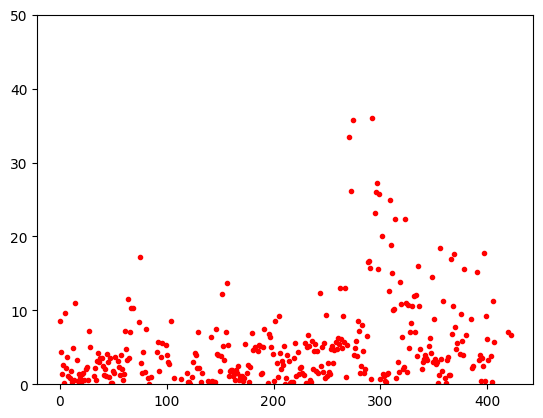

In [328]:
plt.plot((abs(mean1[goodShots] - mean2[goodShots]) * xtcalibrationfactor * 1e6 * 3e8)[0],'r.')
plt.ylim((0,50))
plt.show()


In [330]:
(abs(mean1[goodShots] - mean2[goodShots]) * xtcalibrationfactor * 1e6 * 3e8)[0]

array([8.52873781e+00, 4.37134705e+00, 1.35466576e+00, 2.60143618e+00,
       2.01270273e-01, 9.58361277e+00, 2.25722412e+00, 3.63473296e+00,
       1.06449989e+00, 8.80718708e-01, 1.79862104e+00, 2.49597116e-01,
       4.88150078e+00, 5.64546987e-01, 1.09686837e+01, 1.76387472e+02,
       3.28973379e+00, 3.93232014e-01, 1.43760482e+00, 8.34632935e-01,
       3.27535991e-01, 1.37385996e+00, 1.45857992e+00, 5.52529201e-01,
       2.10978914e+00, 2.34110888e+00, 5.36461650e-01, 7.20490412e+00,
       5.06913247e+00, 9.09909827e+01, 1.77046453e+02, 1.73642712e+02,
       1.12648849e+00, 2.26122115e+00, 5.70080602e-01, 3.08203042e+00,
       4.18276641e+00, 3.07522105e+00, 3.55555627e+00, 3.61744397e+00,
       2.53299461e+00, 1.26456372e+00, 2.06741718e+00, 1.12378340e+00,
       4.05178215e+00, 3.03693016e+00, 9.69619255e-01, 3.61677323e+00,
       1.75948380e-01, 1.94759297e-01, 1.85410384e+00, 1.55296522e+00,
       3.73562153e+00, 1.38315469e+02, 3.10404544e+00, 2.37626936e+00,
      

In [347]:
plus_90_idx[goodShots[0]]

array([  30,   31,   32,   33,   36,   37,   38,   40,   41,   42,   44,
         90,   91,   92,   94,   98,  151,  155,  156,  157,  162,  212,
        214,  216,  218,  219,  220,  221,  249,  302,  307,  356,  358,
        365,  417,  418,  420,  421,  422,  424,  425,  426,  427,  429,
        476,  478,  480,  483,  484,  487,  488,  501,  564,  620,  622,
        623,  625,  630,  632,  634,  682,  683,  684,  685,  687,  688,
        690,  691,  740,  741,  745,  773,  781,  830,  836,  842,  890,
        891,  893,  897,  898,  901,  952,  956,  959,  960, 1038, 1040,
       1042, 1043, 1046, 1047, 1096, 1097, 1098, 1099, 1102, 1103, 1104,
       1105, 1106, 1108, 1110, 1162, 1165, 1167, 1169, 1170, 1171, 1216,
       1217, 1222, 1229, 1245, 1248, 1249, 1252, 1256, 1307, 1310, 1314,
       1315, 1316, 1363, 1364, 1367, 1368, 1369, 1370, 1371, 1372, 1373,
       1375, 1376, 1378, 1425, 1426, 1428, 1433, 1484, 1486, 1488, 1489,
       1490, 1492, 1493, 1510, 1511, 1512, 1514, 15

In [348]:
predictor = bsaScalarData[:,plus_90_idx[goodShots[0]]]
Iz = (abs(mean1[goodShots] - mean2[goodShots]) * xtcalibrationfactor * 1e6 * 3e8)[0]

In [351]:
import sklearn.neural_network as nn
from sklearn import preprocessing

In [355]:
scale_x = preprocessing.MinMaxScaler(feature_range=(0,1))
for col in predictor.columns:
    x_col = predictor[[col]] 
    bsa_scaled = scale_x.fit_transform(x_col)
    predictor[col] = bsa_scaled

c = []

for n in range(predictor.shape[1]):
    X = np.array(predictor)[:,n]
    Y = Iz/np.max(Iz)
    R = np.corrcoef(X, Y)
    c.append(R[0, 1])

c = np.array(c)
c = c[~np.isnan(c)]
absc = np.abs(c)
idx = np.argsort(absc)

predictor = predictor[predictor.columns[idx]]

/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [356]:
predictor

,BPMS_LI14_901_TMIT,BPMS_LI11_362_TMIT,BPMS_LI11_393_TMIT,BPMS_IN10_631_X,BPMS_LI11_358_TMIT,BPMS_LI14_701_TMIT,BPMS_LI14_715_TMIT,TORO_LI11_360_TMIT,TORO_LI20_2040_TMIT,BPMS_LI11_265_Y,...,BPMS_LI20_3265_Y,BPMS_LI14_715_Y,BPMS_LI20_3265_X,BPMS_LI20_3218_X,BPMS_LI20_3315_X,BPMS_LI14_701_Y,BPMS_LI20_3156_Y,BPMS_LI20_2445_X,BPMS_LI14_891_Y,BPMS_LI14_901_Y
0,0.146201,0.141749,0.141552,0.738246,0.143846,0.143525,0.145000,0.138695,0.141332,0.843320,...,0.486593,0.510995,0.555819,0.522803,0.672921,0.549134,0.596807,0.528467,0.334923,0.542728
1,0.133153,0.128809,0.128365,0.790153,0.130317,0.129124,0.131839,0.126827,0.128604,0.901695,...,0.390979,0.517737,0.516680,0.485558,0.643071,0.560331,0.617029,0.536070,0.339361,0.539113
2,0.102666,0.098878,0.099136,0.820935,0.102217,0.099056,0.101444,0.100374,0.095896,0.949832,...,0.562437,0.526581,0.420033,0.381555,0.596322,0.561545,0.552598,0.556639,0.343580,0.532798
3,0.220516,0.214944,0.214708,0.719377,0.217331,0.216275,0.220430,0.214779,0.217292,0.855040,...,0.336204,0.460820,0.442991,0.393197,0.578171,0.492525,0.672115,0.626316,0.455596,0.745911
4,0.163384,0.158327,0.158094,0.689800,0.157856,0.158758,0.162089,0.158658,0.160199,0.847957,...,0.254540,0.520796,0.483771,0.430140,0.634206,0.547023,0.715534,0.521194,0.356307,0.574478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,0.157575,0.154080,0.154487,0.783422,0.154455,0.155009,0.158255,0.157576,0.154102,0.837673,...,0.290270,0.478866,0.334535,0.313308,0.419210,0.524090,0.806206,0.589203,0.322203,0.535060
419,0.144704,0.141123,0.140617,0.782777,0.143038,0.141221,0.144511,0.140856,0.138573,0.850055,...,0.249829,0.479854,0.453418,0.451595,0.518030,0.521801,0.799013,0.411148,0.307771,0.511396
420,0.151898,0.148296,0.147079,0.598560,0.149627,0.148212,0.153016,0.148399,0.148005,0.860897,...,0.226583,0.425395,0.619531,0.583256,0.669758,0.474561,0.847364,0.306569,0.297665,0.514629
421,0.145847,0.142822,0.142951,0.842149,0.142844,0.142734,0.146599,0.142465,0.143557,0.877715,...,0.238745,0.469757,0.335203,0.321240,0.417086,0.515939,0.863959,0.681650,0.334675,0.537472


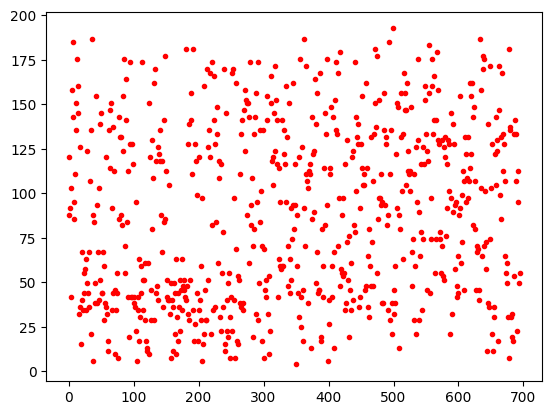

In [180]:
plt.plot(bunch_sep_plus_90_um, 'r.')
plt.show()

In [145]:
goodShots.shape

(1, 243)

### Prepare data for ML model prediction of the driver current

In [331]:
predictor = np.vstack((predictor, data_struct.scalars.steps[good_shots]))

NameError: name 'good_shots' is not defined

array([[9.58435156e+03, 8.70329688e+03, 8.25104688e+03, ...,
        8.08689844e+03, 7.60114844e+03, 7.47050000e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.30000000e+01, 1.30000000e+01, 1.30000000e+01]], shape=(2, 842))

In [ ]:
params = pd.DataFrame(params, columns = ['BLEN', 'steps'])

In [ ]:
params = np.vstack((predictor[100], predictor[-1])).T

In [ ]:
predictor.to_pickle('data/processed/bsaScalarDataE338_12710_good.pkl')
np.save('data/processed/driverPeakE338_12710_good.npy', driverPeak)

In [338]:
predictor.shape

(130, 1, 423)

In [349]:
feature_names = np.array(bsaVars)
predictor = pd.DataFrame(predictor.T, columns = feature_names)

In [39]:
predictor = bsaScalarData[:,plus_90_idx]
driverPeak = np.max(currentProfile_plus_90, axis = 1)

In [37]:
driverPeak = np.max(currentProfile_plus_90[good_shots[0]], axis = 1)
predictor = bsaScalarData[:,plus_90_idx][:,good_shots[0]]

# # removing outliers 
# y = []
# x = []
# for n in range(driverPeak.shape[0]): 
#     if driverPeak[n] > 3 * np.std(driverPeak) + np.average(driverPeak):
#         continue
#     else: 
#         y.append(driverPeak[n])
#         x.append([predictor[:,n]])
# y = np.array(y)
# x = np.concatenate(x, axis = 0 ).T
        

NameError: name 'good_shots' is not defined

R² score = 0.456


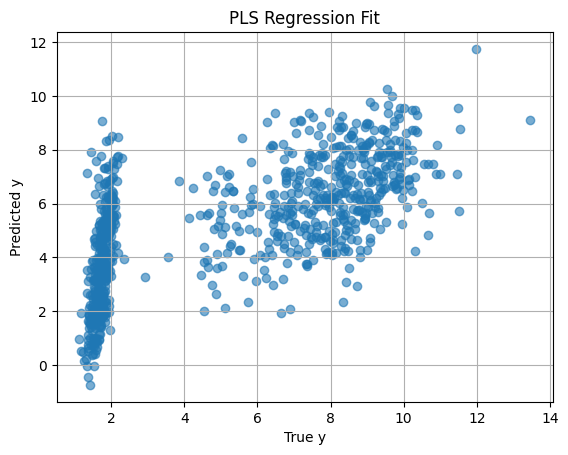

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x.T)

pls = PLSRegression(n_components=10)

pls.fit(X_scaled, y)

X_pls = pls.transform(X_scaled)

y_pred = pls.predict(X_scaled)

from sklearn.metrics import r2_score
r2 = r2_score(y, y_pred)
print(f"R² score = {r2:.3f}")

plt.scatter(y, y_pred, alpha=0.6)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("PLS Regression Fit")
plt.grid(True)
# plt.show()

In [35]:
c

NameError: name 'c' is not defined

In [ ]:
range(len(all_idx))

range(0, 1695)

In [257]:
currentProfile_plus_90 = []

for ij in range(len(plus_90_idx)): 
    idx = plus_90_idx[ij]
    tvar = np.arange(1, len(horz_proj) + 1) * xtcalibrationfactor
    tvar = tvar - np.median(tvar)  # Center around zero
    prefactor = charge[0, idx] / np.trapz(horz_proj[:,idx], tvar)
    currentProfile = 1e-3 * horz_proj[:,idx] * prefactor  # Convert to kA
    currentProfile_plus_90.append(currentProfile)

/var/folders/jc/b9r1lwld74jfg3kzdjjk6_gc0000gn/T/ipykernel_74174/3257494871.py:7: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  prefactor = charge[0, idx] / np.trapz(horz_proj[:,idx], tvar)


In [292]:
np.array(currentProfile_plus_90).shape
m = np.max(np.array(currentProfile_plus_90), axis = 1)

In [293]:
Horz_proj[:,plus_90_idx].shape
p = np.max(Horz_proj[:,plus_90_idx], axis = 0)

In [294]:
np.corrcoef(m, p)

array([[1.        , 0.85087844],
       [0.85087844, 1.        ]])

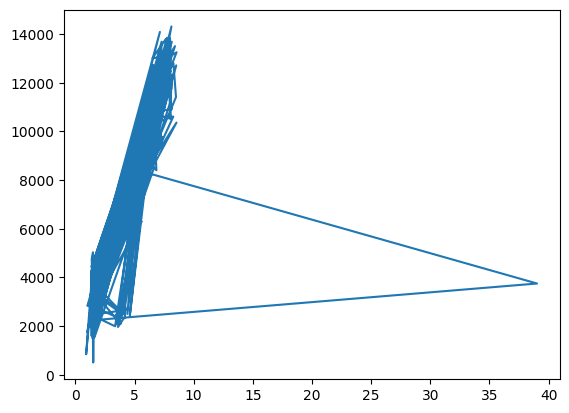

In [295]:
plt.plot(m,p)
plt.show()

/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


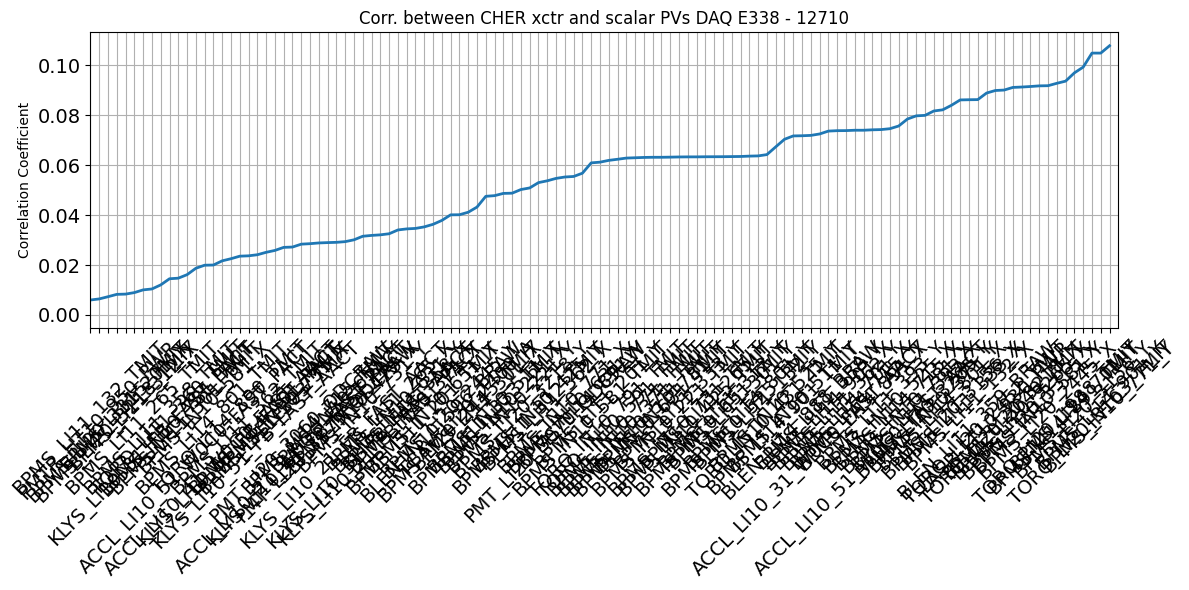

In [117]:
# Plot correlation coefficient between image data and all bsa scalar PVs
c = []

for n in range(predictor.shape[0]):
    X = predictor[n, :]**2
    Y = bunch_sep_plus_90_um
    R = np.corrcoef(X, Y)
    c.append(R[0, 1])

c = np.array(c)
c = c[~np.isnan(c)]
absc = np.abs(c)
idx = np.argsort(absc)

plt.figure(figsize=(12, 6))
plt.plot(absc[idx], linewidth=2)
plt.grid(True)
plt.box(True)
plt.ylabel('Correlation Coefficient')
plt.xticks(ticks=np.arange(np.array(bsaVars)[idx].shape[0]), labels=np.array(bsaVars)[idx], rotation=45, fontsize=10)
plt.xlim([10, len(absc)])
plt.title(f'Corr. between CHER xctr and scalar PVs DAQ {experiment} - {runname}')
plt.gca().tick_params(axis='both', labelsize=14)
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()


In [ ]:
feature_names = np.array(bsaVars)

In [ ]:
data = pd.DataFrame(np.array(predictor)[idx][-30:].T, columns = feature_names)

In [ ]:
pd.DataFrame(driverPeak)

(130,)

In [56]:
steps = data_struct.scalars.steps[DTOTR2commonind]
# bsaScalarData

In [125]:
bsaScalarData[:,all_idx]

array([[ 1.00309616e+10,  1.01425162e+10,  1.05752767e+10, ...,
         1.00458478e+10,  9.92687560e+09,  9.69933075e+09],
       [ 9.96368553e+09,  1.01121140e+10,  1.05544431e+10, ...,
         1.00176477e+10,  9.88720237e+09,  9.62631169e+09],
       [ 1.00694844e+10,  1.01495886e+10,  1.05880154e+10, ...,
         1.00951918e+10,  9.98179649e+09,  9.70062180e+09],
       ...,
       [-8.96853048e+01, -9.05020793e+01, -8.98501041e+01, ...,
         8.99452247e+01,  9.00357951e+01,  8.95779086e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.54998678e+04,  1.54998678e+04,  1.54998678e+04, ...,
         1.54998678e+04,  1.54998678e+04,  1.54998678e+04]],
      shape=(130, 1695))

In [298]:
mat_to_dict(data_struct.scalars)

NameError: name 'mat_to_dict' is not defined

In [135]:
bsaScalarData, bsaVars = extractDAQBSAScalars(data_struct)

In [136]:
bsaScalarData = bsaScalarData[:,plus_90_idx]

In [137]:
goodShots = np.where((bunch_sep_plus_90_um < 250) & (bunch_sep_plus_90_um > 0))[0]

In [142]:
bsaScalarData[:,goodShots]
bunch_sep_plus_90_um = bunch_sep_plus_90_um[goodShots]

In [147]:
y = []
x = []
x_s = []
for n in range(bunch_sep_plus_90_um.shape[0]): 
    if bunch_sep_plus_90_um[n] > 3 * np.std(bunch_sep_plus_90_um) + np.average(bunch_sep_plus_90_um):
        continue
    else: 
        y.append(bunchSeparation_plus_90[n])
        x.append([predictor[:,n]])
        x_s.append(steps[n])
y = np.array(y)
x = np.concatenate(x, axis = 0 ).T
x_s = np.array(x_s)

In [156]:
x

array([[1.04057462e+10, 9.99528933e+09, 1.00205622e+10, ...,
        1.00458478e+10, 9.92687560e+09, 9.69933075e+09],
       [1.03370256e+10, 9.91270528e+09, 9.97416168e+09, ...,
        1.00176477e+10, 9.88720237e+09, 9.62631169e+09],
       [1.04126396e+10, 1.00256404e+10, 1.00619007e+10, ...,
        1.00951918e+10, 9.98179649e+09, 9.70062180e+09],
       ...,
       [8.92685473e+01, 9.01546469e+01, 8.98742690e+01, ...,
        8.99452247e+01, 9.00357951e+01, 8.95779086e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.54998678e+04, 1.54998678e+04, 1.54998678e+04, ...,
        1.54998678e+04, 1.54998678e+04, 1.54998678e+04]], shape=(130, 831))

In [157]:
c = []

for n in range(predictor.shape[0]):
    X = x[n, :]
    Y = y
    R = np.corrcoef(X, Y)
    c.append(R[0, 1])

c = np.array(c)
c = c[~np.isnan(c)]
absc = np.abs(c)
idx = np.argsort(absc)


/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/siddhant/Library/Python/3.12/lib/python/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [357]:
def trunc_norm(mu,sigma,ntrunc,nsamples):
    import scipy.stats as stats
    lower, upper = -ntrunc*sigma, ntrunc*sigma
    X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    out = X.rvs(nsamples)
    return out

In [187]:
feature_names = np.array(bsaVars)[idx][-50:]
feature_names = np.hstack((feature_names, "StepNumber"))

In [193]:
params = pd.DataFrame(params, columns = feature_names)
params['StepNumber']


0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
826    4.0
827    4.0
828    4.0
829    4.0
830    4.0
Name: StepNumber, Length: 831, dtype: float64

In [363]:
predictor.to_pickle('data/processed/predictor.pkl')
np.save('data/processed/bunchSep.npy',bunchSep)

In [ ]:
# save preprocessed data for ML training
bsaScalarData = np.array(predictor)[idx][-10:].T

np.save('data/processed/bsaScalarData.npy', bsaScalarData)
np.save('data/processed/driverPeak.npy', driverPeak)


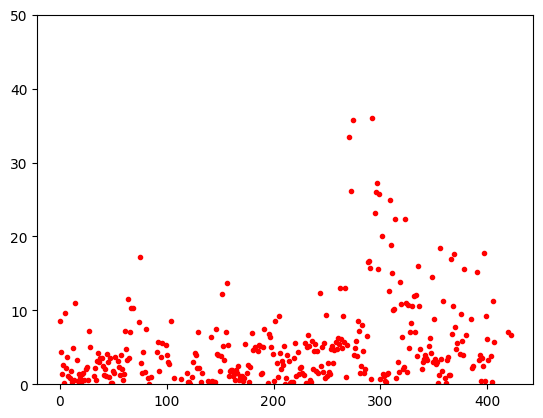

In [367]:
plt.plot(bunchSep,'r.')
plt.ylim((0,50))
plt.show()

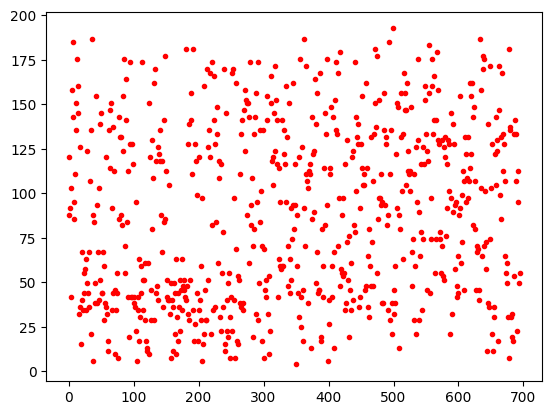

In [368]:
plt.plot(bunch_sep_plus_90_um, 'r.')
plt.show()